In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate
from astropy import table
import h5py
import healpy as hp
import glob
import sys
from pathlib import Path
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
import fastparquet


In [2]:
path_healpix_ids = '/global/homes/y/yoki/roman/desi_like_samples/skysim_5000/data/healpix_ids/id_connected_nums.npy'
healpix_ids = np.load(path_healpix_ids)

LOP_NORTH_AREA = 4400
LOP_SOUTH_DECAL_AREA = 8500
LOP_SOUTH_DES_AREA = 1100
TOTAL_DESI_AREA = 14000
DESI_ELG_ZBIN_WIDTH = 0.05
Z_GRID_POINTS = 201
AREA_PER_HEALPIX = 57.071968/17 # Area of 17 healpix divided by 17
ELG_TARG_DENS_AVG = (1930 + 1950 + 1900) / 3
LOP_ELG_MAG_CUTOFF = 26
NUM_POINTS = int(ELG_TARG_DENS_AVG * AREA_PER_HEALPIX * 40) # overkill to make sure we have more than enough points
DIST_WITHIN_SIM = 1/2 # arcmin
RAND_TO_DATA_RATIO = 10
NSIDE=32

In [3]:
# load in the desi ELG distributions 
path_desi_data = '/global/homes/y/yoki/roman/desi_like_samples/skysim_5000/data/desi_sv_data/desi_elg_ts_zenodo/main-800coaddefftime1200-nz-zenodo.ecsv'
desi_data = table.Table.read(path_desi_data, format='ascii.ecsv')
desi_data.colnames
zmin = desi_data['ZMIN']
zmax = desi_data['ZMAX']

SELECTION_ZBIN_WIDTH = (np.max(zmax) - np.min(zmin)) / (Z_GRID_POINTS - 1)

lop_north = desi_data['ELG_LOP_NORTH']
lop_south_decal = desi_data['ELG_LOP_SOUTH_DECALS']
lop_south_des = desi_data['ELG_LOP_SOUTH_DES']
vlo_north = desi_data['ELG_VLO_NORTH']
vlo_south_decal = desi_data['ELG_VLO_SOUTH_DECALS']
vlo_south_des = desi_data['ELG_VLO_SOUTH_DES']

lop_desi = desi_data['ELG_LOP_DESI']
vlo_desi = desi_data['ELG_VLO_DESI']
weightedavg = (lop_north * LOP_NORTH_AREA + lop_south_decal * LOP_SOUTH_DECAL_AREA  + lop_south_des * LOP_SOUTH_DES_AREA  )/(TOTAL_DESI_AREA)

z_bin_centers = (zmin + zmax ) / 2 
n_of_z = interpolate.interp1d(z_bin_centers, weightedavg / DESI_ELG_ZBIN_WIDTH,  fill_value=0, bounds_error=False) # function to interpolate over

zgrid = np.linspace(np.min(zmin), np.max(zmax), Z_GRID_POINTS )

In [4]:
np.diff(zgrid)

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.

In [7]:
def save_mock_elg_sample(healpix_id=None, area_per_healpix=AREA_PER_HEALPIX):
    # print(f'{worker_index} is processing {healpix_id}')
    

    cat_list = []
    z_range_skysim = [[0,1], [1,2]]

    for z in z_range_skysim:
        
        filepath = '/global/cfs/cdirs/lsst/shared/xgal/skysim/skysim5000_v1.1.1'
        h5_filename = f'/z_{z[0]}_{z[1]}.step_all.healpix_{healpix_id}.hdf5' # assuming all healpix files have same root file name
        h5f = filepath + h5_filename
    
    
        with h5py.File(h5f, 'r') as file:
         
            
            properties = file['galaxyProperties']
            redshift = np.array(properties['redshift'])
            r = cosmo.comoving_distance(redshift).value # units of Mpc
            sfr = np.array(properties['baseDC2']['sfr'])
            sfr_tot = np.array(properties['totalStarFormationRate'])
            stellar_mass = np.array(properties['totalMassStellar'])
            blackhole_mass = np.array(properties['blackHoleMass'])
            gal_id = np.array(properties['galaxyID'])
            mag_u = np.array(properties['LSST_filters']['magnitude:LSST_u:observed:dustAtlas']) # mags with no MW extinction corrections
            mag_g = np.array(properties['LSST_filters']['magnitude:LSST_g:observed:dustAtlas'])
            mag_r = np.array(properties['LSST_filters']['magnitude:LSST_r:observed:dustAtlas'])
            mag_i = np.array(properties['LSST_filters']['magnitude:LSST_i:observed:dustAtlas'])
            mag_z = np.array(properties['LSST_filters']['magnitude:LSST_z:observed:dustAtlas'])
            mag_y = np.array(properties['LSST_filters']['magnitude:LSST_y:observed:dustAtlas'])
            redshift_hubble = np.array(properties['redshiftHubble'])
            ra = np.array(properties['ra'])
            dec = np.array(properties['dec'])
            ra_true = np.array(properties['ra_true'])
            dec_true = np.array(properties['dec_true'])


            array_list = np.column_stack([redshift, r, sfr, sfr_tot, stellar_mass, blackhole_mass, gal_id, mag_u,
                                        mag_g, mag_r, mag_i, mag_z, mag_y,
                                        redshift_hubble, ra, dec, ra_true, dec_true])

            sim_cat = pd.DataFrame(array_list, columns=['redshift', 'r', 'sfr','sfr_tot','stellar_mass','blackhole_mass','gal_id','mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y', 'redshift_hubble', 'ra', 'dec', 'ra_true', 'dec_true'])
            cat_list.append(sim_cat)
            

        sim_cat = pd.concat(cat_list)
        
        print(f'the number of galaxies in this cat is {len(sim_cat)}')
        
        RA_MIN = np.min(ra)
        RA_MAX = np.max(ra)
        
        rand_ra = RA_MIN + (RA_MAX - RA_MIN)*np.random.random(size=NUM_POINTS)
        cth_min = np.min(np.sin(np.radians(sim_cat['dec'])))
        cth_max = np.max(np.sin(np.radians(sim_cat['dec'])))
        cth_rand = cth_min + (cth_max - cth_min)*np.random.random(size=NUM_POINTS)
        rand_dec = np.degrees(np.arcsin(cth_rand))
        
        # Convert to HEALPix θ (colatitude) and φ (longitude)
        rand_theta = np.radians(90.0 - rand_dec)  
        rand_phi = np.radians(rand_ra)            
        
        # Get HEALPix pixel id
        rand_pix_id = hp.ang2pix(NSIDE, rand_theta, rand_phi, nest=False) 
        rand_hpix_mask = rand_pix_id == healpix_id
        
        
        rand_cols_list = np.column_stack([rand_ra[rand_hpix_mask], rand_dec[rand_hpix_mask]])
        rand_cat = pd.DataFrame(rand_cols_list, columns=['ra', 'dec'])
        
        print(f'The number of galaxies that pass hpix mask is {np.sum(rand_hpix_mask)}')


        elg_theta = np.radians(90.0 - sim_cat['dec'])  
        elg_phi = np.radians(sim_cat['ra'])            
        
        # Get HEALPix pixel id
        elg_pix_id = hp.ang2pix(NSIDE, elg_theta, elg_phi, nest=False) 
        elg_hpix_mask = elg_pix_id == healpix_id
        
        
        sim_cat_gmag_mask = sim_cat['mag_g'] < LOP_ELG_MAG_CUTOFF
        elg_masks = np.logical_and(sim_cat_gmag_mask, elg_hpix_mask)
        sim_cat_masked = sim_cat[elg_masks]
        
        
        highest_sfr_gals = []
    
        for zbin_id in range(Z_GRID_POINTS - 1):
    
            zbin_min = zgrid[zbin_id]
            zbin_max = zgrid[zbin_id + 1]
            zbin_mid = (zbin_min + zbin_max) / 2
            z_mask = np.logical_and(sim_cat_masked['redshift'] > zbin_min, sim_cat_masked['redshift'] < zbin_max)

            n_selected = round(n_of_z(zbin_mid) * area_per_healpix * SELECTION_ZBIN_WIDTH)
            top_n_gals = sim_cat_masked[z_mask].nlargest(n_selected, 'sfr_tot')
            highest_sfr_gals.append(top_n_gals)

        
        mock_elg_cat = pd.concat(highest_sfr_gals)
        mock_elg_cat.reset_index(drop=True, inplace=True)

        # add redshifts (or r) to the random catalog for measuring 3D clustering
        rand_cat['r'] = np.random.choice(mock_elg_cat['r'], size=len(rand_cat))
        
        # mask the random cat to have around ten times as many objects as the mock elg cat
        NUM_TO_KEEP = len(mock_elg_cat) * RAND_TO_DATA_RATIO # number of objects to keep for randoms
        rand_cat_final = rand_cat.iloc[:NUM_TO_KEEP]

        return mock_elg_cat, rand_cat_final
        # rand_output_file_name = f'rand_elg_cat_hpix_{healpix_id}'
        # rand_output = f'{rand_output_file_name}.parquet'
        # rand_cat_path = f'/global/homes/y/yoki/roman/desi_like_samples/skysim_5000/data/rands_per_healpix/rands_elg_cat_per_pixel/{rand_output}'
        # rand_cat_final.to_parquet(rand_cat_path)
        
        # output_file_name = f'mock_elg_cat_hpix_{healpix_id}'
        # output = f'{output_file_name}.parquet'
        # mock_elg_cat_path = f'/global/homes/y/yoki/roman/desi_like_samples/skysim_5000/data/mocks_per_healpix/mock_elg_cat_per_pixel/{output}'
        # mock_elg_cat.to_parquet(mock_elg_cat_path)


In [8]:
mock_elg_cat, rand_elg_cat = save_mock_elg_sample(healpix_id=9030)

the number of galaxies in this cat is 868667
The number of galaxies that pass hpix mask is 125411


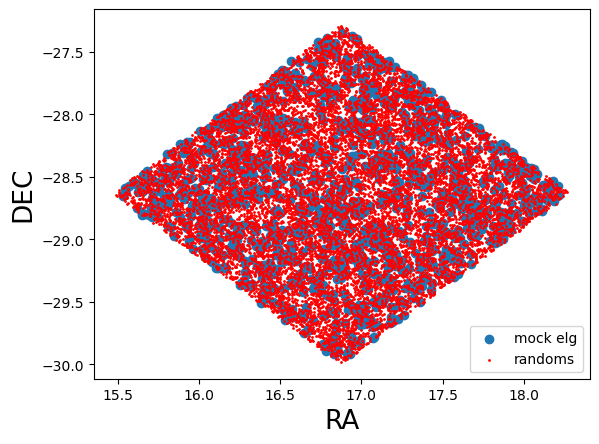

In [9]:
plt.scatter(mock_elg_cat['ra'], mock_elg_cat['dec'], label='mock elg')
plt.scatter(rand_elg_cat['ra'], rand_elg_cat['dec'], label='randoms', s=1, color='red')
# plt.xlim(53, 55)
# plt.ylim(-41, -36)
plt.ylabel('DEC', fontsize=19 )
plt.xlabel('RA', fontsize=19)
plt.legend(loc='lower right')